In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv("/Users/hyunwoo/Desktop/data/BankMarketing/bank.csv",delimiter = ";")

In [2]:
data['y'].value_counts() # 클래스 불균형 데이터셋 

no     4000
yes     521
Name: y, dtype: int64

# EDA

In [3]:
data.info() #nullvalue 존재하지 않음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [4]:
data.describe() # Balance, duration 컬럼 , pdays , previous컬럼에 이상치값들을 max()로 확인할 수 있음

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [5]:
# 문자열 데이터 모으기 
data[data.columns[data.dtypes==object]] 

,job,marital,education,default,housing,loan,contact,month,poutcome,y
0,unemployed,married,primary,no,no,no,cellular,oct,unknown,no
1,services,married,secondary,no,yes,yes,cellular,may,failure,no
2,management,single,tertiary,no,yes,no,cellular,apr,failure,no
3,management,married,tertiary,no,yes,yes,unknown,jun,unknown,no
4,blue-collar,married,secondary,no,yes,no,unknown,may,unknown,no
...,...,...,...,...,...,...,...,...,...,...
4516,services,married,secondary,no,yes,no,cellular,jul,unknown,no
4517,self-employed,married,tertiary,yes,yes,yes,unknown,may,unknown,no
4518,technician,married,secondary,no,no,no,cellular,aug,unknown,no
4519,blue-collar,married,secondary,no,no,no,cellular,feb,other,no


<AxesSubplot:ylabel='Density'>

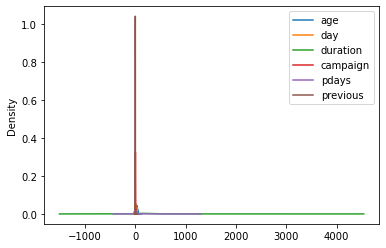

In [6]:
density_col = data.columns[data.dtypes!=object]
data.plot(kind = 'kde',x = 'balance')

In [7]:
density_col

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')

In [8]:
cat_col = data.columns[data.dtypes ==object]

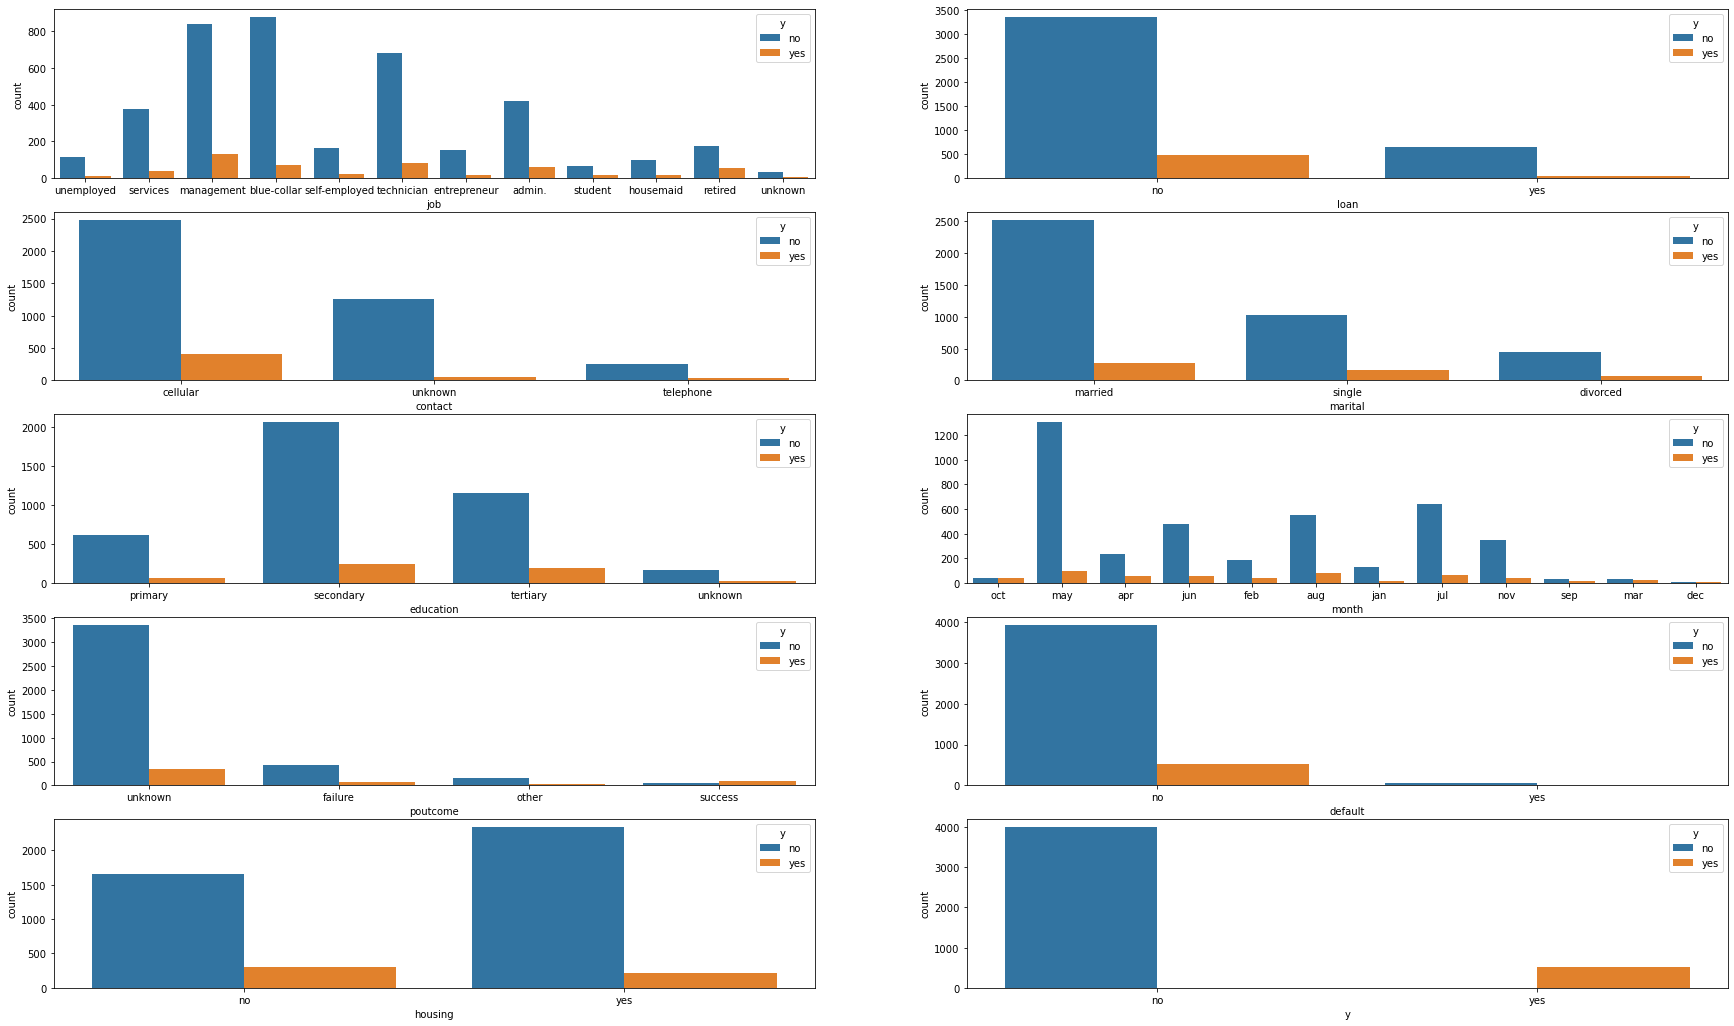

In [9]:
#범주형 데이터셋 그래프 시각화
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
fig, axes = plt.subplots(nrows = 5,ncols = 2,figsize=(30,18))
for i,column in enumerate(cat_col):
    row = i%5 
    col = i%2
    sns.countplot(data =data, x =column ,hue = 'y',ax = axes[row,col])

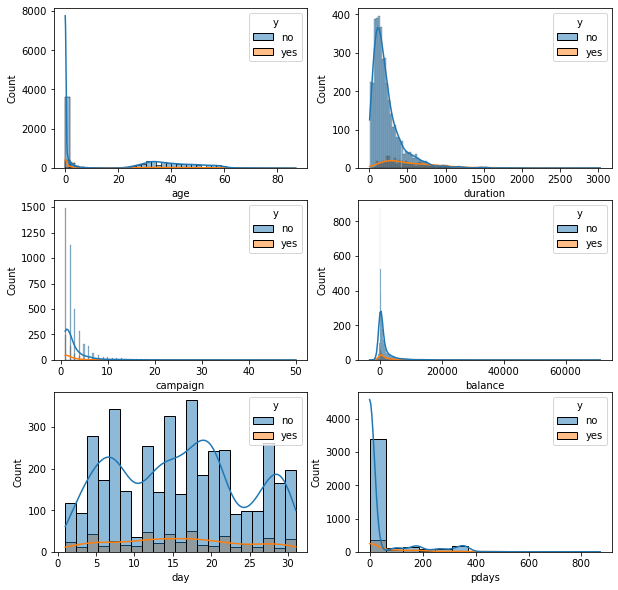

In [10]:
fig, axes = plt.subplots(nrows=3,ncols =2,figsize =(10,10))
for i,column in enumerate(density_col):
    rows = i%3
    cols = i%2
    sns.histplot(data =data ,x = column , ax = axes[rows,cols],kde = True,hue='y')
    # 나이 = 0 빈도가 제일많음 나이 0 인건 말이안됨 금융고객중 -> 전처리 필요함
    # 
median = data['age'].median()
data.loc[data['age'] == 0, 'age'] = median    

In [11]:
import numpy as np
data['logbalance']= np.log1p(data['balance']) 
data['logduration'] = np.log1p(data['duration'])

/Users/hyunwoo/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/hyunwoo/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='logduration', ylabel='Count'>

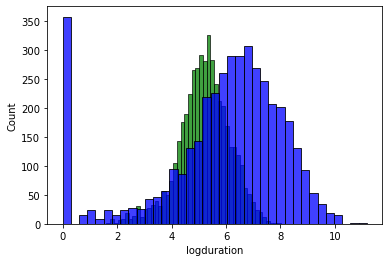

In [12]:
sns.histplot(data =data , x= "logduration",color = 'g')
sns.histplot(data =data , x= "logbalance",color ='b')

# LogisticRegression 모델링 Oversampling 적용 전

In [13]:
#class Imbance 해결 전 모델링
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

data.loc[data['y']=="yes",'y']=1
data.loc[data['y']=="no",'y']=0
data['y'] = data['y'].astype(int)
data.drop(["logduration","logbalance"],inplace=True,axis =1)


X_data = data.drop("y",axis= 1)
y_data = data['y']

X_data = pd.get_dummies(X_data)


logclf = LogisticRegression()
params = {"C" : [0.1,1,2,3,5,10]}
gvc = GridSearchCV(logclf , param_grid = params,cv =5,scoring = "f1_micro")

pipeline = Pipeline([("mmscaler",MinMaxScaler()),("model",gvc)])
pipeline.fit(X_data,y_data)

/Users/hyunwoo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/hyunwoo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/li

/Users/hyunwoo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/hyunwoo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/li

Pipeline(steps=[('mmscaler', MinMaxScaler()),
                ('model',
                 GridSearchCV(cv=5, estimator=LogisticRegression(),
                              param_grid={'C': [0.1, 1, 2, 3, 5, 10]},
                              scoring='f1_micro'))])

In [14]:
pd.DataFrame(gvc.cv_results_)[['params','mean_test_score']]

,params,mean_test_score
0,{'C': 0.1},0.891396
1,{'C': 1},0.899360
2,{'C': 2},0.901573
3,{'C': 3},0.901794
4,{'C': 5},0.902458
5,{'C': 10},0.902016


In [15]:
gvc.best_score_

0.9024580746100817

In [16]:
#데이터 로그로 변환후
import numpy as np

X_data['balance']= np.log1p(data['balance']) 
X_data['duration'] = np.log1p(data['duration'])


X_data.loc[X_data['balance'].isnull(),"balance"] = 0 
X_data.loc[X_data['balance'] == -np.inf,'balance'] = 0.5
#계좌 잔고가 -인 계좌들이 존재함 해당 로그값을 0으로 바꿔줌

logclf2 = LogisticRegression()
gvc2 = GridSearchCV(logclf2 , param_grid = params,cv =5,scoring = "f1_micro")
pipeline2 = Pipeline([("mmscaler",MinMaxScaler()),("model",gvc2)])
pipeline2.fit(X_data,y_data)


/Users/hyunwoo/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/hyunwoo/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/hyunwoo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/hyunwoo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_

/Users/hyunwoo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/hyunwoo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/li

Pipeline(steps=[('mmscaler', MinMaxScaler()),
                ('model',
                 GridSearchCV(cv=5, estimator=LogisticRegression(),
                              param_grid={'C': [0.1, 1, 2, 3, 5, 10]},
                              scoring='f1_micro'))])

In [17]:
pd.DataFrame(gvc2.cv_results_)[['params','mean_test_score']] ## MINMAX스케일러때문인지 크게 차이는 없음 

,params,mean_test_score
0,{'C': 0.1},0.892281
1,{'C': 1},0.898697
2,{'C': 2},0.899139
3,{'C': 3},0.902900
4,{'C': 5},0.903121
5,{'C': 10},0.901794


# 오버샘플링 적용후 로지스틱 모델링

In [18]:
#SMOTE 이용해 클래스 불균형 처리 
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
#X_data.drop("logbalance",inplace=True,axis =1)



y = data['y']


X_data = pd.get_dummies(data[data.columns[:-1]])

mmscaler = MinMaxScaler()
mmscaler.fit(X_data)
X_data = mmscaler.transform(X_data)

X_train,X_test,y_train,y_test = train_test_split(X_data,y,test_size = 0.2)

In [19]:
from sklearn.metrics import f1_score

logclf = LogisticRegression(C = 5)
logclf.fit(X_train,y_train)
pred = logclf.predict(X_test)
f1_score(y_test,pred)

/Users/hyunwoo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.4210526315789474

In [20]:
smote = SMOTE(random_state=0)
X_train_over,y_train_over = smote.fit_resample(X_train,y_train)

In [21]:
logclf.fit(X_train_over,y_train_over)
pred = logclf.predict(X_test)
f1_score(y_test,pred)

/Users/hyunwoo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.5371024734982331

<AxesSubplot:>

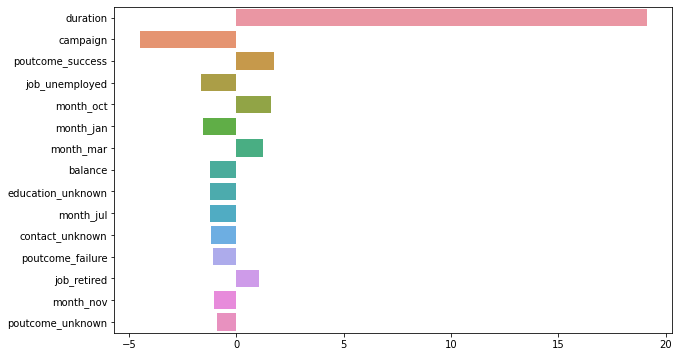

In [22]:
coef = pd.Series(logclf.coef_[0],index= pd.get_dummies(data[data.columns[:-1]]).columns)
coef.sort_values(ascending = False,inplace=True,key = abs)
plt.figure(figsize=(10,6))
coef = coef[:15]
sns.barplot(x = coef.values,y=coef.index)

# 오버샘플링 적용전 랜덤포레스트 모델링

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
rf = RandomForestClassifier()
label = LabelEncoder()

X = data.drop("y",axis =1)
X = X.apply(label.fit_transform)
# 랜덤포레스트는 변수 값에 가중치를 두는게아니라 기준으로 분류를 하는것이기때문에 더미변수를 써서 변수개수를 늘리는것 보다
# 라벨 인코딩을 쓰는것이 더 효율적이고 정확함
y = data['y']

params = {"max_depth" : [1,5,7,10,12], "n_estimators" :[10,50,100,150,200]}

gvc3 = GridSearchCV(rf , param_grid = params,cv =5,scoring = "f1_micro")
gvc3.fit(X,y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 5, 7, 10, 12],
                         'n_estimators': [10, 50, 100, 150, 200]},
             scoring='f1_micro')

In [24]:
pd.DataFrame(gvc3.cv_results_)[['params','mean_test_score']]

,params,mean_test_score
0,"{'max_depth': 1, 'n_estimators': 10}",0.884760
1,"{'max_depth': 1, 'n_estimators': 50}",0.884760
2,"{'max_depth': 1, 'n_estimators': 100}",0.884760
3,"{'max_depth': 1, 'n_estimators': 150}",0.884760
4,"{'max_depth': 1, 'n_estimators': 200}",0.884760
5,"{'max_depth': 5, 'n_estimators': 10}",0.889848
6,"{'max_depth': 5, 'n_estimators': 50}",0.889184
7,"{'max_depth': 5, 'n_estimators': 100}",0.890069
8,"{'max_depth': 5, 'n_estimators': 150}",0.889405
9,"{'max_depth': 5, 'n_estimators': 200}",0.887636


# 오버샘플링 적용후 랜덤포레스트 모델링

In [25]:
X_data = X
X_train,X_test,y_train,y_test = train_test_split(X_data,y,test_size = 0.2)

smote = SMOTE(random_state=0)
X_train_over,y_train_over = smote.fit_resample(X_train,y_train)

In [26]:
params = {"max_depth" : [1,5,7,10,12], "n_estimators" :[50,100,150,200]}

gvc3 = GridSearchCV(rf , param_grid = params,cv =5,scoring = "f1_micro")
gvc3.fit(X_train_over,y_train_over)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 5, 7, 10, 12],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='f1_micro')

In [27]:
pd.DataFrame(gvc3.cv_results_)[['params','mean_test_score']]

,params,mean_test_score
0,"{'max_depth': 1, 'n_estimators': 50}",0.796774
1,"{'max_depth': 1, 'n_estimators': 100}",0.803824
2,"{'max_depth': 1, 'n_estimators': 150}",0.814325
3,"{'max_depth': 1, 'n_estimators': 200}",0.820436
4,"{'max_depth': 5, 'n_estimators': 50}",0.862120
5,"{'max_depth': 5, 'n_estimators': 100}",0.861021
6,"{'max_depth': 5, 'n_estimators': 150}",0.861334
7,"{'max_depth': 5, 'n_estimators': 200}",0.861021
8,"{'max_depth': 7, 'n_estimators': 50}",0.887503
9,"{'max_depth': 7, 'n_estimators': 100}",0.888913


In [28]:
pred = gvc3.best_estimator_.predict(X_test)
f1_score(y_test,pred)

0.5523012552301255

In [29]:
from lightgbm import LGBMClassifier

In [30]:
params = {"learning_rate" : [0.01,0.05,0.2]}
lgb  = LGBMClassifier()

gvc = GridSearchCV(lgb , param_grid = params,cv =5,scoring = "f1_micro")
gvc.fit(X_data,y_data)

GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.01, 0.05, 0.2]},
             scoring='f1_micro')

In [31]:
pd.DataFrame(gvc.cv_results_)[['params','mean_test_score']]

,params,mean_test_score
0,{'learning_rate': 0.01},0.887634
1,{'learning_rate': 0.05},0.892060
2,{'learning_rate': 0.2},0.892278


In [32]:
gvc = GridSearchCV(lgb , param_grid = params,cv =5,verbose=1)
gvc.fit(X_train_over,y_train_over)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.01, 0.05, 0.2]}, verbose=1)

In [33]:
pd.DataFrame(gvc.cv_results_)[['params','mean_test_score']]

,params,mean_test_score
0,{'learning_rate': 0.01},0.879042
1,{'learning_rate': 0.05},0.911793
2,{'learning_rate': 0.2},0.929185


In [34]:
pred = gvc.best_estimator_.predict(X_test)
f1_score(y_test,pred)

0.5490196078431373

<AxesSubplot:>

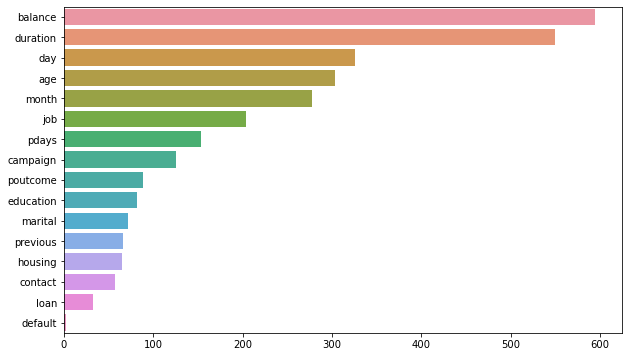

In [35]:
feature = pd.Series(gvc.best_estimator_.feature_importances_)
feature.index = X_data.columns
feature.sort_values(ascending = False,inplace=True)
plt.figure(figsize=(10,6))
sns.barplot(x = feature.values,y=feature.index)

In [36]:
data.groupby('y').describe()[['duration','balance']]

duration                                                            balance  \
     count        mean         std   min    25%    50%    75%     max   count   
y                                                                               
0   4000.0  226.347500  210.313631   4.0   96.0  167.0  283.0  3025.0  4000.0   
1    521.0  552.742802  390.325805  30.0  260.0  442.0  755.0  2769.0   521.0   

                                                                    
          mean          std     min    25%    50%     75%      max  
y                                                                   
0  1403.211750  3075.349313 -3313.0   61.0  419.5  1407.0  71188.0  
1  1571.955854  2444.398956 -1206.0  171.0  710.0  2160.0  26965.0

In [43]:
LGBMClassifier?